# State Farm Classification Exercise
## 1. Data cleaning

In [1]:
#standard import
import numpy as np
import pandas as pd
import os 
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

### 1.1 loading and exploring the data

## 1.3 Prepare the data transformation pipeline

In [2]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler #, StandardScaler
from sklearn.compose import ColumnTransformer

## 1.5 Store prepared data in a pandas DataFrame:

Find column names for transformed data (including one-hot transformed features)

Find transformed column names

In [3]:
# save data locally
# train_transformed.to_pickle(os.path.join('train_transformed_minmax_final.pkl'))
# test_transformed.to_pickle(os.path.join('test_transformed_minmax_final.pkl'))

In [4]:
import pickle

In [5]:
train_transformed = pd.read_pickle(os.path.join('train_transformed_minmax_final.pkl'))

In [6]:
train_transformed.y.value_counts()

0.0    34197
1.0     5803
Name: y, dtype: int64

# 2 Modeling 
Create X & y objects with train_transformed

In [7]:
X = train_transformed.drop(['y'], axis=1)
y = train_transformed.y

In [8]:
X.shape

(40000, 180)

In [9]:
y.shape

(40000,)

Generate X_train, X_test, y_train & y_test. Use 80% for train & 20% for test.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.2, random_state = 365) 

## 2.1 logistic regression model

In [11]:
# Import classification model:
from sklearn.linear_model import LogisticRegression

# Import other tools:
from sklearn.metrics import precision_recall_curve, auc, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

### 2.1.1 Run quick logistic regression model

In [12]:
LR = LogisticRegression(multi_class='ovr')

In [13]:
# Default hyperparameters
print(LR.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [14]:
%%time
# Fit model
LR.fit(X_train, y_train)

CPU times: user 1.87 s, sys: 72.1 ms, total: 1.94 s
Wall time: 534 ms


LogisticRegression(multi_class='ovr')

### 2.1.3 Test optimized model against test set

In [15]:
y_pred_test_LR = LR.predict(X_test)

In [16]:
# Classification report
print(classification_report(y_test, y_pred_test_LR))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.92      6883
         1.0       0.52      0.09      0.16      1117

    accuracy                           0.86      8000
   macro avg       0.70      0.54      0.54      8000
weighted avg       0.82      0.86      0.82      8000



In [17]:
# Confusion matrix
print(confusion_matrix(y_test, y_pred_test_LR))

[[6786   97]
 [1012  105]]


### 2.1.4 Evaluate AUC for ROC and PR for performance against test set

For imbalanced targets, area under the precision-recall curve is usually a better indicator of model performance than area under the receiver operating characteristic curve.

In [18]:
# Find probability estimates for y_pred_test
y_pred_proba_test_LR = LR.predict_proba(X_test)[:, 1] # use second column for probabilities

In [19]:
# Calculate false positive rate and true positive rate:
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba_test_LR)

# Calculate precision and recall
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_pred_proba_test_LR)

In [20]:
# Area under curve for ROC
auc(fpr, tpr)

0.7539943428407098

In [21]:
# Area under precision-recall curve
auc(recall, precision)

0.3535523719372374

In [22]:
# Visualization
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
from sklearn.dummy import DummyClassifier

In [ ]:
def plot_pr_curve(test_y, model_probs):
	# calculate the no skill line as the proportion of the positive class
	no_skill = len(test_y[test_y==1]) / len(test_y)
	# plot the no skill precision-recall curve
	pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

In [41]:
# no skill model, stratified random class predictions
model = DummyClassifier(strategy='stratified')
model.fit(X_train, y_train)
yhat = model.predict_proba(X_test)
naive_probs = yhat[:, 1]

# Calculate false positive rate and true positive rate:
naive_fpr, naive_tpr, naive_thresholds_roc = roc_curve(y_test, naive_probs)

# Calculate precision and recall
naive_precision, naive_recall, naive_thresholds_pr = precision_recall_curve(y_test, naive_probs)

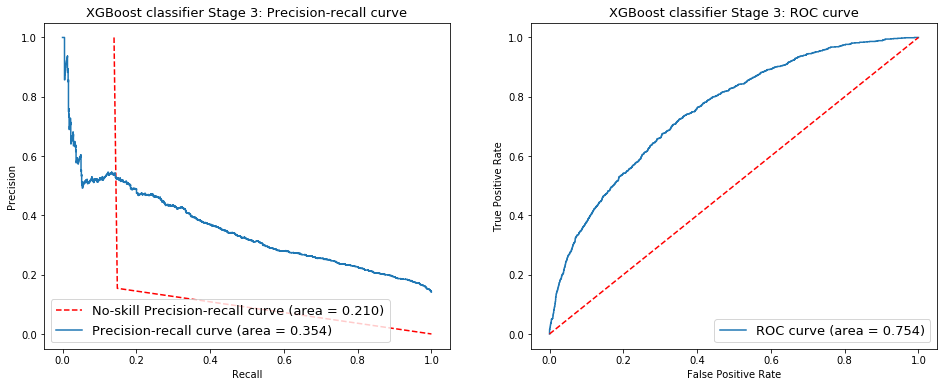

In [46]:
# Plot Precision-Recall curve for clf_best:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(naive_precision, naive_recall, 'r--', label='No-skill Precision-recall curve (area = %0.3f)' % auc(naive_recall, naive_precision))
plt.step(recall, precision,label='Precision-recall curve (area = %0.3f)' % auc(recall, precision))
plt.title('XGBoost classifier Stage 3: Precision-recall curve', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize=13)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

# Plot ROC curve for clf_best:
plt.subplot(1,2,2)
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'r--')
plt.title('XGBoost classifier Stage 3: ROC curve', size=13)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=13)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

plt.show()

## 2.2 DNN in Keras model

In [24]:
# Import Keras and Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Create validation set from training data to evaluate model training

In [25]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train,test_size = 0.2, random_state = 365) 

### Convert pandas dataframes to NumPy arrays

NOTE: In order to use validation_split or validation_data during model training, the training data should be in NumPy format.

In [26]:
X_train_train_np = X_train_train.to_numpy()
y_train_train_np = y_train_train.to_numpy()
X_train_val_np = X_train_val.to_numpy()
y_train_val_np = y_train_val.to_numpy()

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

### 2.2.1 Run a quick DNN model 

In [27]:
# Create Sequential model with 2 hidden layers

DNN = keras.Sequential()
DNN.add(layers.Dense(300, input_shape=(X_train.shape[1],), activation='relu', name='layer1'))
DNN.add(layers.Dense(100, activation='relu', name='layer2'))
DNN.add(layers.Dense(30, activation='relu', name='layer3'))
DNN.add(layers.Dense(1, activation='sigmoid', name='ouput'))

In [28]:
DNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (Dense)               (None, 300)               54300     
_________________________________________________________________
layer2 (Dense)               (None, 100)               30100     
_________________________________________________________________
layer3 (Dense)               (None, 30)                3030      
_________________________________________________________________
ouput (Dense)                (None, 1)                 31        
Total params: 87,461
Trainable params: 87,461
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Compile model
DNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])

In [30]:
 %%time

 # Use early stopping if model does not improve after 5 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

 # Fit model
 history = DNN.fit(X_train_train_np, y_train_train_np,
                    epochs=20,
                    validation_data=(X_train_val_np, y_train_val_np),
                    callbacks=[early_stopping_cb]) 

Train on 25600 samples, validate on 6400 samples
Epoch 1/20
25600/25600 [==============================] - 2s 67us/sample - loss: 0.3946 - accuracy: 0.8522 - AUC: 0.6674 - val_loss: 0.3769 - val_accuracy: 0.8548 - val_AUC: 0.7176
Epoch 2/20
25600/25600 [==============================] - 1s 45us/sample - loss: 0.3711 - accuracy: 0.8542 - AUC: 0.7339 - val_loss: 0.3723 - val_accuracy: 0.8558 - val_AUC: 0.7407
Epoch 3/20
25600/25600 [==============================] - 1s 45us/sample - loss: 0.3582 - accuracy: 0.8585 - AUC: 0.7621 - val_loss: 0.3799 - val_accuracy: 0.8566 - val_AUC: 0.7417
Epoch 4/20
25600/25600 [==============================] - 1s 49us/sample - loss: 0.3500 - accuracy: 0.8600 - AUC: 0.7783 - val_loss: 0.3708 - val_accuracy: 0.8566 - val_AUC: 0.7322
Epoch 5/20
25600/25600 [==============================] - 1s 48us/sample - loss: 0.3341 - accuracy: 0.8666 - AUC: 0.8033 - val_loss: 0.3812 - val_accuracy: 0.8464 - val_AUC: 0.7247
Epoch 6/20
25600/25600 [======================

In [31]:
# Evaluate against test set
DNN_test_loss, DNN_test_acc, DNN_test_auc = DNN.evaluate(X_test_np, y_test_np)
print('deep neural network quick Test loss: \t%0.4f' % DNN_test_loss)
print('deep neural network quick Test accuracy: \t%0.4f' % DNN_test_acc)
print('deep neural network quick Test AUC: \t%0.4f' % DNN_test_auc)

8000/8000 [==============================] - 0s 23us/sample - loss: 0.3606 - accuracy: 0.8609 - AUC: 0.7375
deep neural network quick Test loss: 	0.3606
deep neural network quick Test accuracy: 	0.8609
deep neural network quick Test AUC: 	0.7375


In [32]:
# Find probability estimates
y_pred_proba_test_quick_DNN = DNN.predict(X_test_np) # use predict for probabilities

In [33]:
# # Calculate false positive rate and true positive rate:
DNN_fpr_quick, DNN_tpr_quick, DNN_thresholds_roc_quick = roc_curve(y_test_np, y_pred_proba_test_quick_DNN)

# # Calculate precision and recall
DNN_precision_quick, DNN_recall_quick, DNN_thresholds_pr_quick = precision_recall_curve(y_test_np, y_pred_proba_test_quick_DNN)

In [34]:
# Area under curve for ROC
auc(DNN_fpr_quick, DNN_tpr_quick)

0.7373758033461445

In [35]:
# Area under precision-recall curve
auc(DNN_recall_quick, DNN_precision_quick)

0.3322175302704722

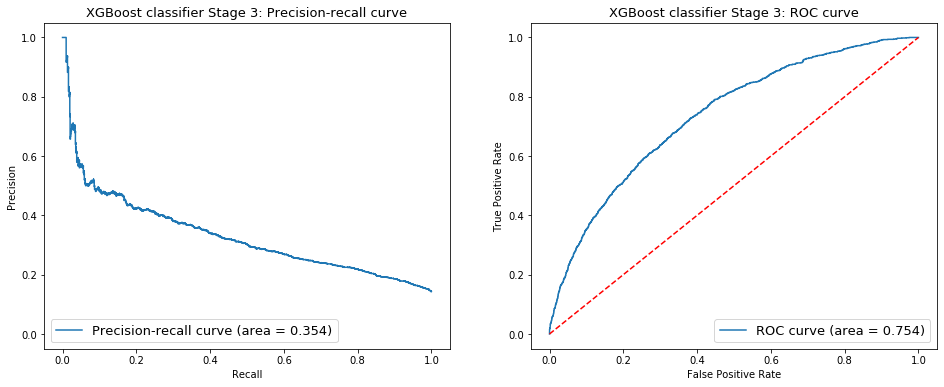

In [36]:
# Plot Precision-Recall curve for clf_best:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.step(DNN_recall_quick, DNN_precision_quick, label='Precision-recall curve (area = %0.3f)' % auc(recall, precision))

plt.title('XGBoost classifier Stage 3: Precision-recall curve', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left', fontsize=13)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

# Plot ROC curve for clf_best:
plt.subplot(1,2,2)
plt.plot(DNN_fpr_quick, DNN_tpr_quick, label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'r--')
plt.title('XGBoost classifier Stage 3: ROC curve', size=13)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right', fontsize=13)
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

plt.show()

# 4 Compare the modeling approaches